<a href="https://colab.research.google.com/github/davenust/TinyML/blob/main/microplastic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import requests
import zipfile
from pathlib import Path
import tqdm
import os

data_path = Path("/content/microplastic")
image_path = data_path / "/content/microplastic"

In [59]:
import os
def walk_through_dir(dir_path):
  # walks through dir_path returning its contents
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/microplastic'.
There are 6 directories and 0 images in '/content/microplastic/train'.
There are 0 directories and 33 images in '/content/microplastic/train/Fragments'.
There are 0 directories and 30 images in '/content/microplastic/train/Spheres'.
There are 0 directories and 39 images in '/content/microplastic/train/Rubber'.
There are 0 directories and 33 images in '/content/microplastic/train/Fibers'.
There are 0 directories and 33 images in '/content/microplastic/train/Foams'.
There are 0 directories and 32 images in '/content/microplastic/train/Films'.
There are 6 directories and 0 images in '/content/microplastic/test'.
There are 0 directories and 23 images in '/content/microplastic/test/Fragments'.
There are 0 directories and 13 images in '/content/microplastic/test/Spheres'.
There are 0 directories and 24 images in '/content/microplastic/test/Rubber'.
There are 0 directories and 19 images in '/content/microplastic/test/Fibers'.
Th

In [60]:
cd '/content/microplastic/test'

/content/microplastic/test


In [61]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [62]:
ls -l

total 24
drwxr-xr-x 2 root root 4096 Jul 31 16:15 Fibers/
drwxr-xr-x 2 root root 4096 Jul 31 16:15 Films/
drwxr-xr-x 2 root root 4096 Jul 31 16:16 Foams/
drwxr-xr-x 2 root root 4096 Jul 31 16:16 Fragments/
drwxr-xr-x 2 root root 4096 Jul 31 16:17 Rubber/
drwxr-xr-x 2 root root 4096 Jul 31 16:17 Spheres/


In [63]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/content/microplastic/train'),
 PosixPath('/content/microplastic/test'))

In [64]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) #any one of the file in the path list
image_path_list

[PosixPath('/content/microplastic/test/Fragments/26_27.jpg'),
 PosixPath('/content/microplastic/test/Fragments/34_35.jpg'),
 PosixPath('/content/microplastic/test/Fragments/21_22.jpg'),
 PosixPath('/content/microplastic/test/Fragments/37.jpg'),
 PosixPath('/content/microplastic/test/Fragments/20_21 (1).jpg'),
 PosixPath('/content/microplastic/test/Fragments/22.jpg'),
 PosixPath('/content/microplastic/test/Fragments/30_31.jpg'),
 PosixPath('/content/microplastic/test/Fragments/12_13.jpg'),
 PosixPath('/content/microplastic/test/Fragments/18_19.jpg'),
 PosixPath('/content/microplastic/test/Fragments/24_25.jpg'),
 PosixPath('/content/microplastic/test/Fragments/38 (1).jpg'),
 PosixPath('/content/microplastic/test/Fragments/30.jpg'),
 PosixPath('/content/microplastic/test/Fragments/33_34.jpg'),
 PosixPath('/content/microplastic/test/Fragments/36.jpg'),
 PosixPath('/content/microplastic/test/Fragments/42_43.jpg'),
 PosixPath('/content/microplastic/test/Fragments/33.jpg'),
 PosixPath('/conte

Random image path: /content/microplastic/test/Films/13.jpg
Image class: Films
Image height: 1944
Image width: 2592
Image size: (2592, 1944)


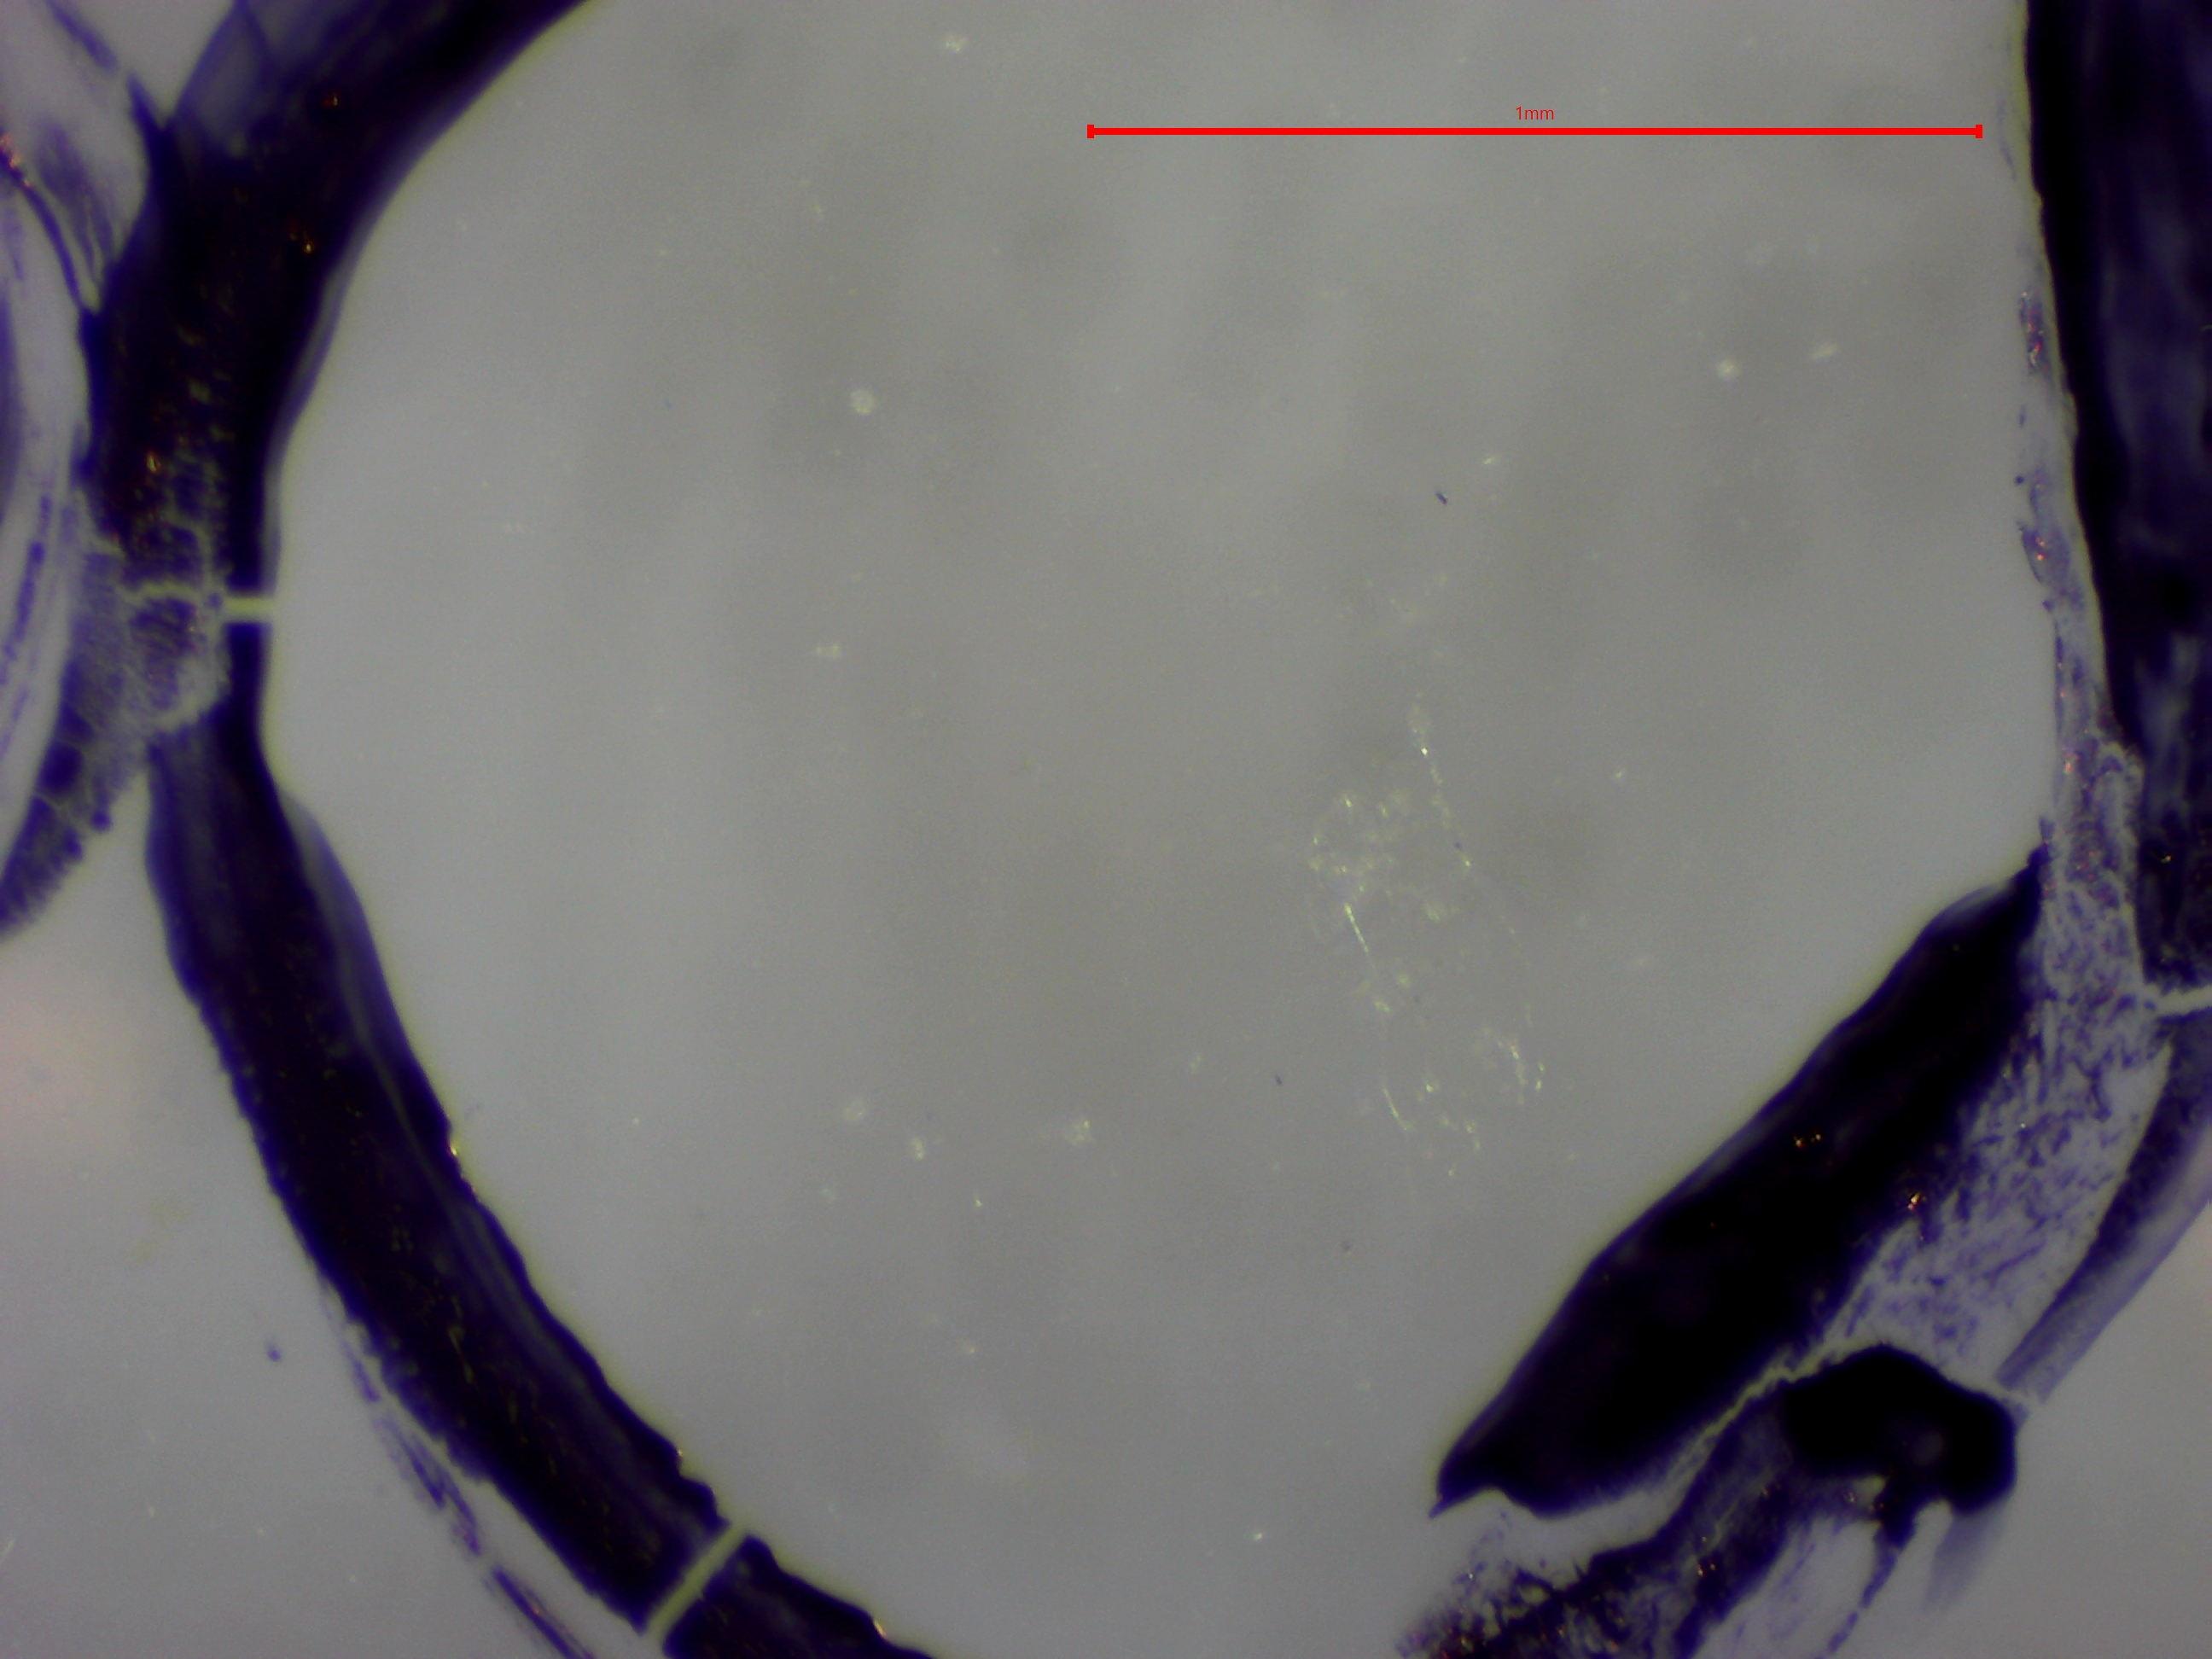

In [65]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) #any one of the file in the path list
#image_path_list

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
#print(random_image_path)

# 3. Get the image class from the image path name
image_class = random_image_path.parent.stem
#print(image_class)

# 4. Open image
img = Image.open(random_image_path)
#print(img)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image size: {img.size}")
img

(-0.5, 2591.5, 1943.5, -0.5)

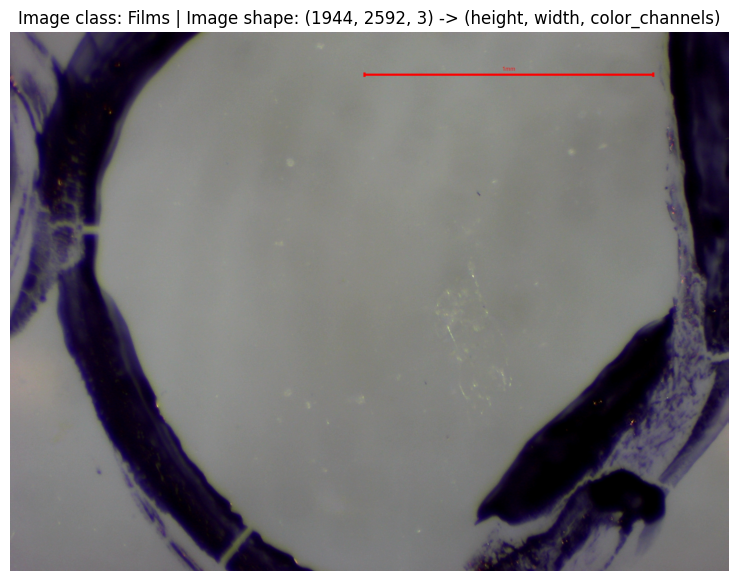

In [66]:
# matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> (height, width, color_channels)")
plt.axis(False)
#

In [67]:
img_as_array.shape

(1944, 2592, 3)

In [68]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [69]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [70]:
data_transform(img).shape

torch.Size([3, 64, 64])

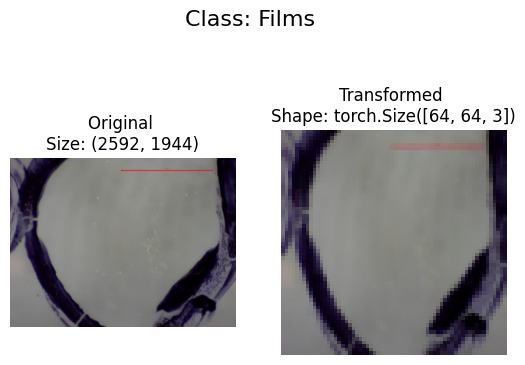

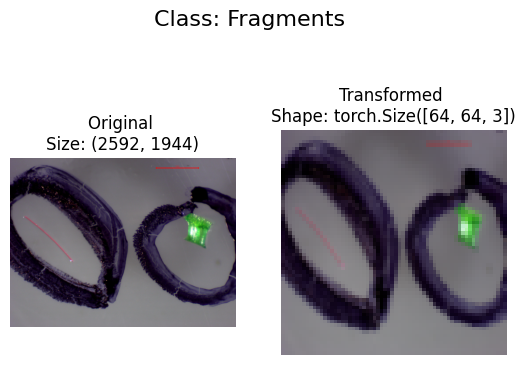

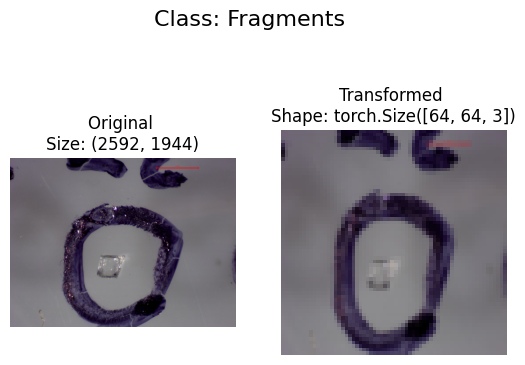

In [71]:
# Visualize
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """Selects random images from a path of images and loads/transforms them plots the original vs the transformed version"""

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib from (C, H, W) TO ()
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, data_transform, n=3, seed=42)


      # Print metadata


In [72]:
# Use ImageFolder to create datasets
import os
import torch
from torchvision import datasets, transforms

train_data = datasets.ImageFolder(train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")
#val_data = datasets.ImageFolder(val_dir, transform=data_transform)

Train data:
Dataset ImageFolder
    Number of datapoints: 200
    Root location: /content/microplastic/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 101
    Root location: /content/microplastic/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [73]:
# Get Class name as a list
class_name = train_data.classes
class_name

['Fibers', 'Films', 'Foams', 'Fragments', 'Rubber', 'Spheres']

In [74]:
#Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'Fibers': 0,
 'Films': 1,
 'Foams': 2,
 'Fragments': 3,
 'Rubber': 4,
 'Spheres': 5}

In [75]:
# Checkthe lenghts of our datasets
len(train_data), len(test_data)

(200, 101)

In [76]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], test_data[0][0]
print(f"Image shape: {img}")
print(f"Image datatype: {img.dtype}")
print(f"Image size: {img.size}")
print(f"Image label: {label}")

Image shape: tensor([[[0.4863, 0.4863, 0.4784,  ..., 0.4039, 0.4039, 0.4000],
         [0.4824, 0.4824, 0.4784,  ..., 0.4039, 0.4039, 0.4000],
         [0.4824, 0.4824, 0.4745,  ..., 0.4039, 0.4039, 0.4039],
         ...,
         [0.5882, 0.5882, 0.5843,  ..., 0.4745, 0.4706, 0.4667],
         [0.5922, 0.5882, 0.5843,  ..., 0.4784, 0.4745, 0.4706],
         [0.5922, 0.5882, 0.5882,  ..., 0.4784, 0.4745, 0.4706]],

        [[0.4314, 0.4314, 0.4314,  ..., 0.3608, 0.3608, 0.3608],
         [0.4314, 0.4314, 0.4353,  ..., 0.3686, 0.3686, 0.3686],
         [0.4314, 0.4353, 0.4353,  ..., 0.3686, 0.3725, 0.3686],
         ...,
         [0.5529, 0.5569, 0.5608,  ..., 0.4510, 0.4510, 0.4431],
         [0.5529, 0.5569, 0.5608,  ..., 0.4510, 0.4471, 0.4431],
         [0.5529, 0.5529, 0.5569,  ..., 0.4510, 0.4431, 0.4392]],

        [[0.5098, 0.5059, 0.4980,  ..., 0.4157, 0.4157, 0.4157],
         [0.5059, 0.5020, 0.4941,  ..., 0.4157, 0.4157, 0.4157],
         [0.5059, 0.5020, 0.4941,  ..., 0.415

In [77]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)
img_permute

# Print out different shapes
print(f"Image shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")
#

Image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


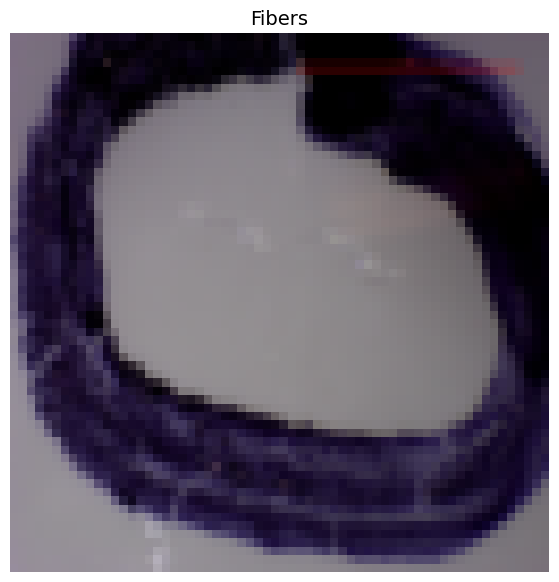

In [78]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)
img_permute

# Print out different shapes
print(f"Image shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

#plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
# Convert label to a Python integer before using it as an index
label_index = label.item() if isinstance(label, torch.Tensor) and label.numel() == 1 else 0
plt.title(class_name[label_index], fontsize=14);

In [79]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=1) # shuffle the training data
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
shuffle=False,
                             num_workers=1)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7856bf86ac20>,
 <torch.utils.data.dataloader.DataLoader at 0x7856bf86acb0>)

In [80]:
len(train_dataloader), len(test_dataloader)

(200, 101)

In [81]:
img, label = next(iter(train_dataloader))

# batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [85]:
# Let's look at Trivia Augment

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # Now operates on a tensor
    transforms.ToTensor() # Moved before TrivialAugmentWide

])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])


In [86]:
# Get all images paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('/content/microplastic/test/Fragments/26_27.jpg'),
 PosixPath('/content/microplastic/test/Fragments/34_35.jpg'),
 PosixPath('/content/microplastic/test/Fragments/21_22.jpg'),
 PosixPath('/content/microplastic/test/Fragments/37.jpg'),
 PosixPath('/content/microplastic/test/Fragments/20_21 (1).jpg'),
 PosixPath('/content/microplastic/test/Fragments/22.jpg'),
 PosixPath('/content/microplastic/test/Fragments/30_31.jpg'),
 PosixPath('/content/microplastic/test/Fragments/12_13.jpg'),
 PosixPath('/content/microplastic/test/Fragments/18_19.jpg'),
 PosixPath('/content/microplastic/test/Fragments/24_25.jpg')]

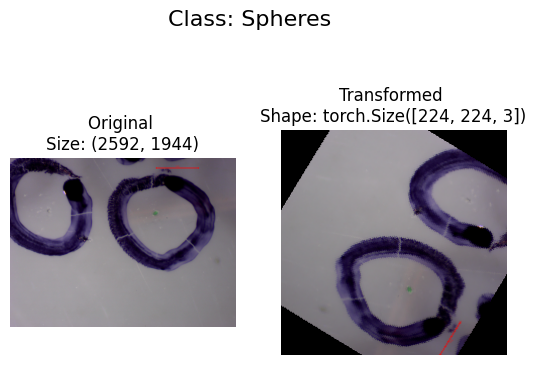

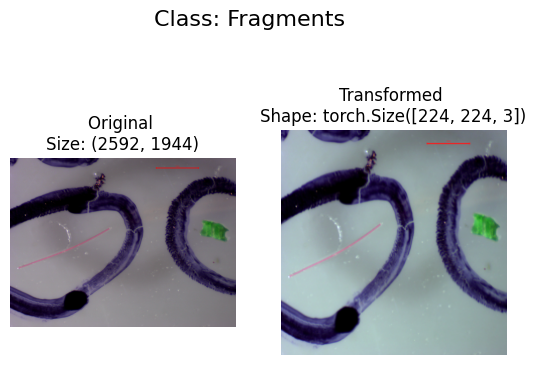

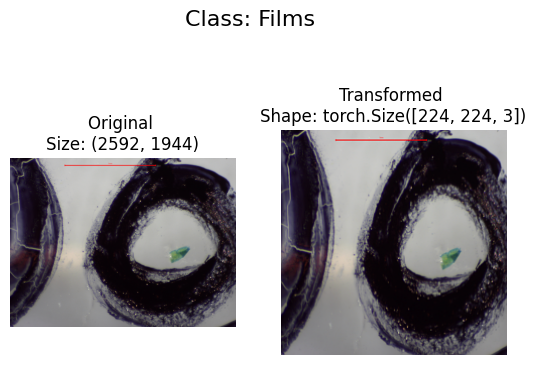

In [87]:
# plot random transformed image
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

In [88]:
# creating simple transforms
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [92]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                       transform=simple_transform,
                                       target_transform=None)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)
#
# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)
train_dataloader_simple, test_dataloader_simple
#



(<torch.utils.data.dataloader.DataLoader at 0x7856bf838c10>,
 <torch.utils.data.dataloader.DataLoader at 0x7856bfd99ba0>)

In [107]:
import torch.nn as nn
class TinyVGG(nn.Module):

  """Creates the TinyVGG architecture"""
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                    stride=2) # default stride value is the same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                    stride=2) # default stride value is the same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
    #return self.classifier(self.conv_block_2(self.conv_block_1(x)))




In [108]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_simple.classes))
model_0
#

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=6, bias=True)
  )
)

In [109]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
#image_single, label_single = image_batch[0].unsqueeze(dim=0), label_batch[0]
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [110]:
# Try a forward pass
model_0(image_batch)

tensor([[ 2.9768e-02,  5.1249e-04,  3.6535e-02,  6.9164e-03,  7.3492e-04,
          6.1060e-03],
        [ 3.0716e-02,  2.4776e-03,  3.0214e-02,  8.8318e-04, -1.9017e-03,
          2.8385e-03],
        [ 3.1283e-02,  2.6513e-03,  2.9213e-02,  4.1385e-04, -1.1152e-03,
          4.9413e-03],
        [ 3.1195e-02,  3.3657e-03,  3.1204e-02,  8.1904e-04, -2.3695e-03,
          3.3778e-03],
        [ 3.0309e-02,  2.1262e-03,  2.9990e-02,  9.5569e-04, -1.2879e-03,
          5.8688e-03],
        [ 2.9584e-02,  2.9005e-03,  3.1324e-02,  3.0816e-03, -2.1756e-04,
          3.2132e-03],
        [ 3.0390e-02,  2.6773e-03,  3.1601e-02,  2.6879e-04,  9.5226e-04,
          5.5311e-03],
        [ 2.7673e-02,  1.2658e-03,  3.5778e-02,  4.3444e-03, -7.0067e-04,
          4.5174e-03],
        [ 3.1253e-02,  2.7368e-03,  3.1175e-02,  2.4460e-03,  1.0333e-03,
          5.3065e-03],
        [ 2.9167e-02,  3.8347e-03,  2.9772e-02,  3.8959e-03, -4.1306e-03,
         -8.4370e-04],
        [ 3.2265e-02,  8.1854e

In [112]:
# install torchinfo, import if its available
try:
    import torchinfo
except:
    !pip install torchinfo
    import torch

from torchinfo import summary
summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 6]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [124]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [125]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [126]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [128]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Check for GPU and set device
device = "cuda" if torch.cuda.is_available() else "cpu" # Define device here

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7997 | train_acc: 0.1875 | test_loss: 1.8038 | test_acc: 0.1875
Epoch: 2 | train_loss: 1.7895 | train_acc: 0.1875 | test_loss: 1.7920 | test_acc: 0.1875
Epoch: 3 | train_loss: 1.7918 | train_acc: 0.2009 | test_loss: 1.7849 | test_acc: 0.1875
Epoch: 4 | train_loss: 1.7833 | train_acc: 0.2009 | test_loss: 1.7885 | test_acc: 0.1875
Epoch: 5 | train_loss: 1.7745 | train_acc: 0.1875 | test_loss: 1.7918 | test_acc: 0.1875
Total training time: 110.173 seconds
